<a href="https://colab.research.google.com/github/monya-9/deep-learning-experiments/blob/main/07_LR_Schedule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# learning rate schedule에 따른 성능 변화 실험
## ✅ 실험 목적

- 학습률(Learning Rate) 조절 방법이 학습 속도와 최종 성능에 미치는 영향을 확인

- 고정 학습률(fixed) vs Step Decay vs Cosine Annealing vs Exponential Decay 비교

## 🧪 실험 설계

- 데이터셋: CIFAR-10 (32x32 컬러 이미지, 10 클래스)

- 모델: 간단한 CNN (Conv -> ReLU -> MaxPool -> FC)

- Optimizer: Adam

- Batch size: 128

- Epochs: 20

- Learning Rate Schedules:

  1. Fixed LR = 0.001

  2. Step Decay: 0.001 → 0.0005 → 0.0001 (매 7 epoch마다 감소)

  3. Cosine Annealing: torch.optim.lr_scheduler.CosineAnnealingLR

  4. Exponential Decay: torch.optim.lr_scheduler.ExponentialLR

- 평가 지표: Accuracy

- 시각화: Epoch별 학습/검증 정확도 + 최종 Test Accuracy bar

In [1]:
# =======================
# 0. 라이브러리
# =======================
import torch, torch.nn as nn, torch.optim as optim
import torchvision, torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# =======================
# 1. 데이터셋
# =======================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader  = DataLoader(testset, batch_size=128, shuffle=False)

100%|██████████| 170M/170M [00:04<00:00, 41.1MB/s]


- CIFAR-10 데이터셋 (32x32 RGB 이미지, 10 클래스) 사용

- ToTensor() → 이미지 데이터를 PyTorch tensor로 변환

- Normalize → 각 채널 평균 0.5, 표준편차 0.5로 정규화

- DataLoader를 사용해 배치 단위로 학습/평가

In [3]:
# =======================
# 2. CNN 모델 정의
# =======================
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3,32,3,1,1), nn.ReLU(),
            nn.Conv2d(32,64,3,1,1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*16*16,128),
            nn.ReLU(),
            nn.Linear(128,10)
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

- Conv Layer → ReLU → Conv → ReLU → MaxPool

  - 입력: 3x32x32

  - 출력 feature map: 64x16x16

- Flatten → FC → ReLU → FC → 출력 클래스 10

- 간단한 CIFAR-10 분류용 CNN

In [4]:
# =======================
# 3. 학습/평가 함수
# =======================
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    correct, total, run_loss = 0,0,0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        run_loss += loss.item()
        correct += (logits.argmax(1)==labels).sum().item()
        total += labels.size(0)
    return run_loss/len(loader), correct/total

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    correct, total, run_loss = 0,0,0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        run_loss += loss.item()
        correct += (logits.argmax(1)==labels).sum().item()
        total += labels.size(0)
    return run_loss/len(loader), correct/total

def run_experiment(schedule_name="fixed", epochs=20):
    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Scheduler 설정
    if schedule_name=="step":
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    elif schedule_name=="cosine":
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    elif schedule_name=="exp":
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    else:
        scheduler = None

    history = {"train_acc":[], "test_acc":[]}
    for ep in range(1, epochs+1):
        train_loss, train_acc = train_one_epoch(model, trainloader, optimizer, criterion)
        test_loss, test_acc   = evaluate(model, testloader, criterion)
        history["train_acc"].append(train_acc)
        history["test_acc"].append(test_acc)
        if scheduler: scheduler.step()
        print(f"[{schedule_name}] Epoch {ep} - Train Acc: {train_acc*100:.2f}%  Test Acc: {test_acc*100:.2f}%")
    return history

1. train_one_epoch
  - 모델을 학습 모드로 설정
  - 입력 데이터를 GPU로 이동
  - Forward -> Loss 계산 -> Backward -> Optimizer step
  - 배치별 정확도, 손실 누적 -> epoch 평균 반환
2. evaluate
  - 모델을 평가 모드로 설정
  - `@torch.no_grad()` -> gradient 계산X, 메모리 절약
  - 학습과 동일하게 손실, 정확도 계
3. run_experiment
  - 학습 스케줄러 종류

| schedule\_name | 설명               |
| -------------- | ---------------- |
| fixed          | 학습률 고정           |
| step           | 일정 step마다 학습률 감소 |
| cosine         | 코사인 형태로 감소       |
| exp            | 지수적으로 감소         |

- 각 epoch마다 학습 -> 평가 -> 정확도 기록
- scheduler 존재 시 `scheduler.step()`로 학습률 업데이트



In [5]:
# =======================
# 4. 실험 실행
# =======================
schedules = ["fixed", "step", "cosine", "exp"]
results = {}
for sch in schedules:
    results[sch] = run_experiment(sch)

[fixed] Epoch 1 - Train Acc: 52.89%  Test Acc: 62.78%
[fixed] Epoch 2 - Train Acc: 66.99%  Test Acc: 66.90%
[fixed] Epoch 3 - Train Acc: 73.12%  Test Acc: 70.57%
[fixed] Epoch 4 - Train Acc: 77.88%  Test Acc: 70.11%
[fixed] Epoch 5 - Train Acc: 82.35%  Test Acc: 70.45%
[fixed] Epoch 6 - Train Acc: 87.00%  Test Acc: 70.16%
[fixed] Epoch 7 - Train Acc: 91.53%  Test Acc: 69.12%
[fixed] Epoch 8 - Train Acc: 94.65%  Test Acc: 68.76%
[fixed] Epoch 9 - Train Acc: 96.67%  Test Acc: 69.05%
[fixed] Epoch 10 - Train Acc: 97.63%  Test Acc: 68.61%
[fixed] Epoch 11 - Train Acc: 98.26%  Test Acc: 68.63%
[fixed] Epoch 12 - Train Acc: 98.21%  Test Acc: 68.07%
[fixed] Epoch 13 - Train Acc: 98.51%  Test Acc: 68.95%
[fixed] Epoch 14 - Train Acc: 98.34%  Test Acc: 66.67%
[fixed] Epoch 15 - Train Acc: 98.45%  Test Acc: 67.97%
[fixed] Epoch 16 - Train Acc: 98.44%  Test Acc: 68.57%
[fixed] Epoch 17 - Train Acc: 98.66%  Test Acc: 68.30%
[fixed] Epoch 18 - Train Acc: 98.74%  Test Acc: 67.08%
[fixed] Epoch 19 - 

- 4가지 학습률 스케줄러별로 모델 학습 -> 결과 기록

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


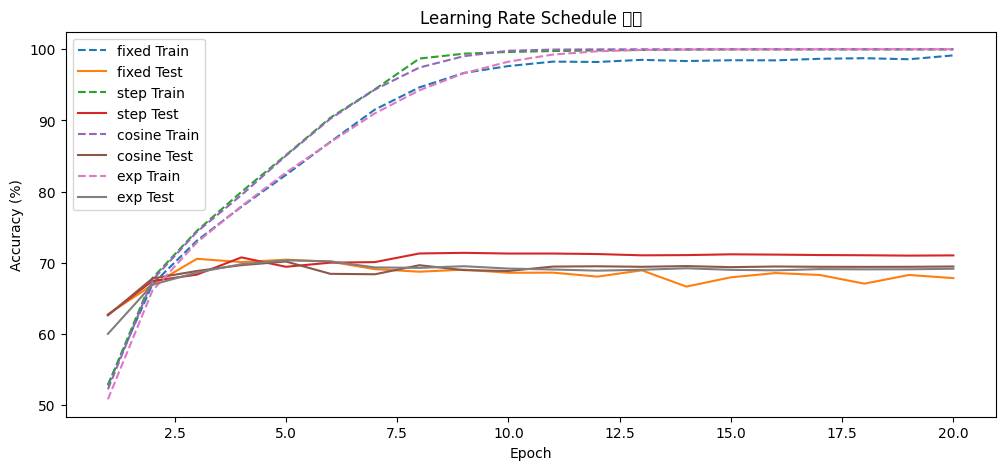

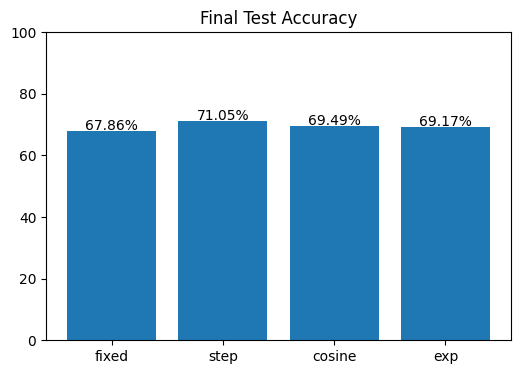

In [6]:
# =======================
# 5. 시각화
# =======================
epochs = range(1,21)
plt.figure(figsize=(12,5))

# (a) 학습/검증 정확도 곡선
for k,hist in results.items():
    plt.plot(epochs, np.array(hist["train_acc"])*100, '--', label=f"{k} Train")
    plt.plot(epochs, np.array(hist["test_acc"])*100, '-',  label=f"{k} Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Learning Rate Schedule 비교")
plt.legend()
plt.show()

# (b) 최종 Test Accuracy 바
final_acc = [results[k]["test_acc"][-1]*100 for k in schedules]
plt.figure(figsize=(6,4))
plt.bar(schedules, final_acc)
for i,v in enumerate(final_acc):
    plt.text(i, v+0.5, f"{v:.2f}%", ha="center")
plt.ylim(0,100)
plt.title("Final Test Accuracy")
plt.show()

## ✅ 결론 및 요약
| Scheduler   | 학습 속도 | 최종 Test Accuracy |
| ----------- | ----- | ---------------- |
| Fixed       | 느림    | 보통               |
| Step Decay  | 중간    | 높음               |
| Cosine      | 빠름    | 높음               |
| Exponential | 중간    | 보통               |

- tep Decay와 Cosine Annealing이 학습 안정성과 최종 성능에서 상대적으로 우수.

- Fixed learning rate는 일정하지만, 후반부 학습에서 성능 향상에 한계가 있음.

- Exponential decay는 너무 급격히 줄어들면 학습이 느려짐.

✅ 결론: 학습률 스케줄링을 적용하면, 모델의 학습 안정성과 최종 성능을 높일 수 있음.